In [1]:
import os
import pandas as pd
from pandas.io.json import json_normalize
import datetime
import numpy as np
import json
import matplotlib.pylab as plt
import seaborn as sb

%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 8)

# Part 1 - Exploratory Data Analysis

Goals:
-  Aggregate login counts based on 15-minute time intervals
-  visualize and describe the resulting time series of login counts in ways that best characterize theunderlying patterns of the demand
-  report/illustrate important features of the demand such as daily cycles
-  report data quality issues

In [2]:
# read file in string format
str_data = json.load(open('logins.json'))
# using json normalize record the key 'login_time'
logins = json_normalize(str_data, record_path='login_time')
# set the column name to date
logins.columns = ['date']
# add a column 'val' with each row value set to 1
# we can group by date and aggregate on 'val' column
logins['val'] = 1
# convert date column to pandas datetime 
logins['date'] = pd.to_datetime(logins['date'])
# set date column as index
logins.set_index('date', inplace=True)

In [3]:
logins.head()

,val
date,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [4]:
def resample(df, interval):
    # resample the dataframe 
    temp_resample = df.resample(interval).count()
    return temp_resample

In [5]:
def interval_plot(df, axis, title, y_label=''):
    plt.subplot(axis)
    plt.plot(df['val'])
    plt.ylabel(y_label)
    plt.title(title)
    plt.tight_layout()

In [6]:
#resampling
min15 = resample(logins, '15Min')
hourly = resample(logins, '60Min')
daily = resample(logins, 'D')
monthly = resample(logins, 'M')

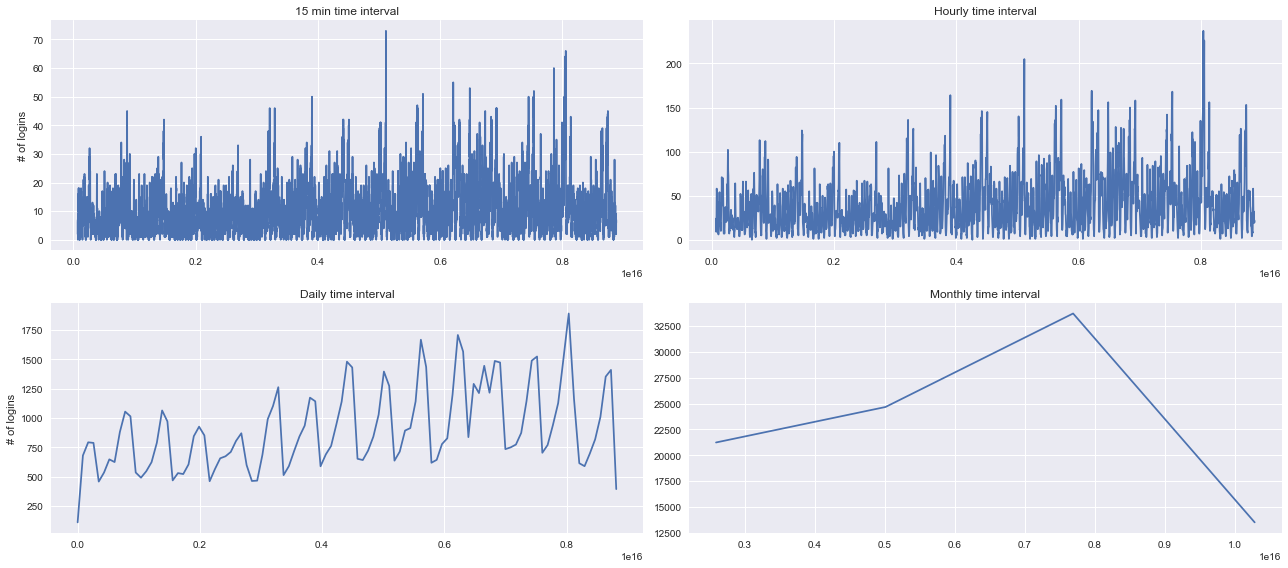

In [7]:
# 15 Min
interval_plot(min15, 221, "15 min time interval", "# of logins")
# Hourly
interval_plot(hourly, 222, "Hourly time interval")
# Daily
interval_plot(daily, 223, "Daily time interval", "# of logins")
# Monthly
interval_plot(monthly, 224, "Monthly time interval")
plt.show()

# Part 2 - Experiment and Metrics Design

## Problem
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
    - how you will implement the experiment
    - what statistical test(s) you will conduct to verify the significance of the observation 
    - how you would interpret the results and provide recommendations to the city operations team along with any caveats.

## Solution

The only measure of success in that could validate this experiment, implicitly is customer activity in both cities being increased due to the more drivers being available in both cities. If customer activity is significantly enhanced in both cities then that would show positive results. A simple quantitative metric that we could observe is the comparison of the number of times a driver crossed the bridge pre reimbursement and post reimbursement.

Since the standard deviation of our customer activity will be known prior to attempting this, I would use a 1-sample z statistic with the assumption that we have a sample size of at least 30. 

-  $h_0$ : there is no difference between drivers crossing the bridge for when the company is not reimbursing drivers for toll costs and when the company is reimbursing drivers for toll cost
-  $h_1$ : there is a difference between drivers crossing the bridge for when the company is not reimbursing drivers for toll costs and when the company is reimbursing drivers for toll cost
-  I would then calculate the z-score for the customer activity after implementation of the reimbursement
-  Then using a 95% confidence interval I would determine whether or not the z-score falls in that range, and observe whether or not the null hypothesis can be rejected
-  If it can be rejected then I would recommend that the company continue to reimburse toll costs and continue to observe the number of times drivers are crossing the bridge to make sure company money is well spent

# Part 3 - Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provideddata for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention

## Exploratory Analysis

In [8]:
data = json.load(open('ultimate_data_challenge.json'))
df = pd.DataFrame(data)

In [9]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [10]:
df.shape

(50000, 12)

In [11]:
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

In [12]:
last_day = max(df['last_trip_date'])
days = [last_day - datetime.timedelta(days=x) for x in range(0, 30)]
df['retained_user'] = df['last_trip_date'].map(lambda x: int(x in days))

In [13]:
active_df = df[df['retained_user'] == 1]
non_active_df = df[df['retained_user'] == 0]
percent_active = len(active_df) / len(df)
print('Percentage of Retained users: {0}'.format(percent_active))

Percentage of Retained users: 0.3662


In [14]:
df['active_user'] = ((df['last_trip_date'] - df['signup_date']) / np.timedelta64(1, 'M')).\
        map(lambda x: 'active' if x > 5 else 'inactive')

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


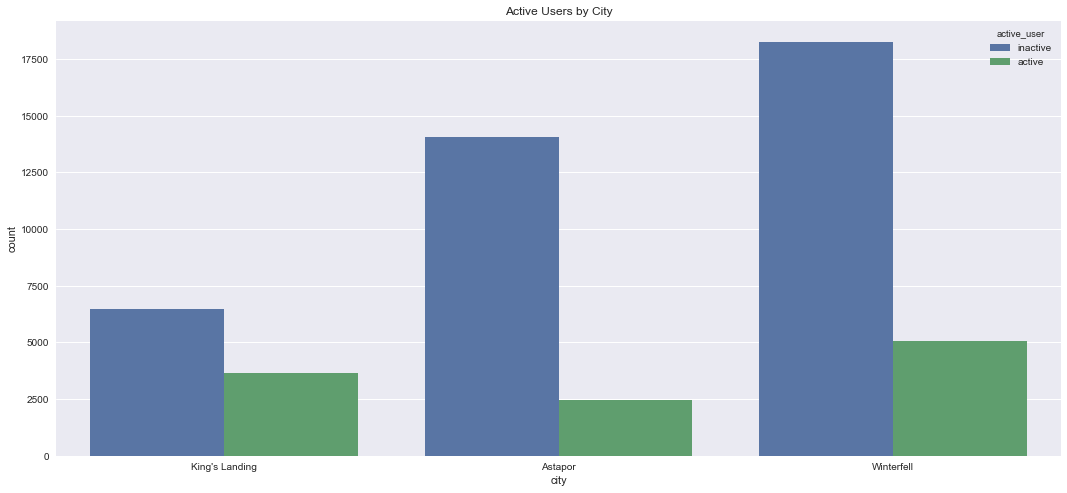

In [15]:
sb.countplot(x='city', hue='active_user', data=df)
plt.title('Active Users by City')
plt.show()

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


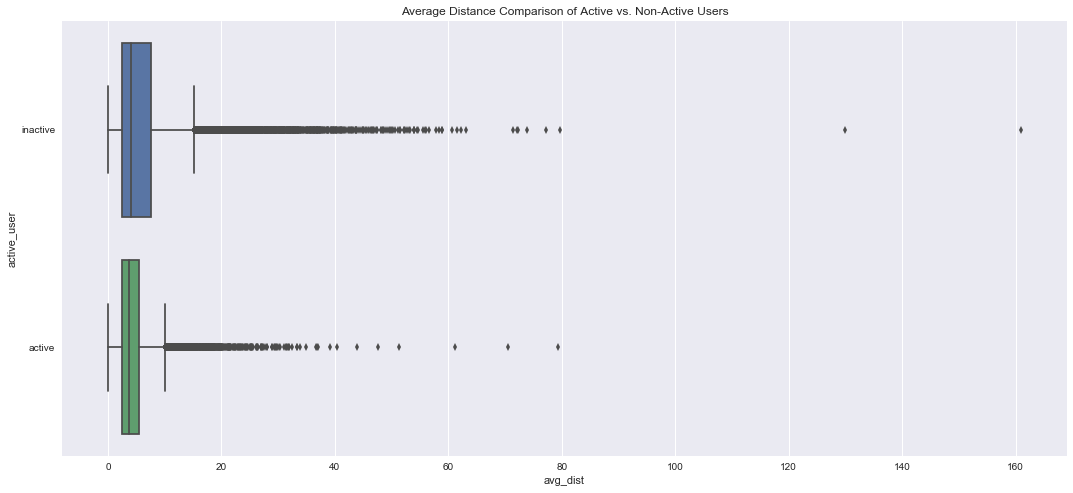

In [16]:
sb.boxplot(x='avg_dist', y='active_user', data=df)
plt.title('Average Distance Comparison of Active vs. Non-Active Users')
plt.show()

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:637: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data[hue_mask])
//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:932: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data[hue_mask])


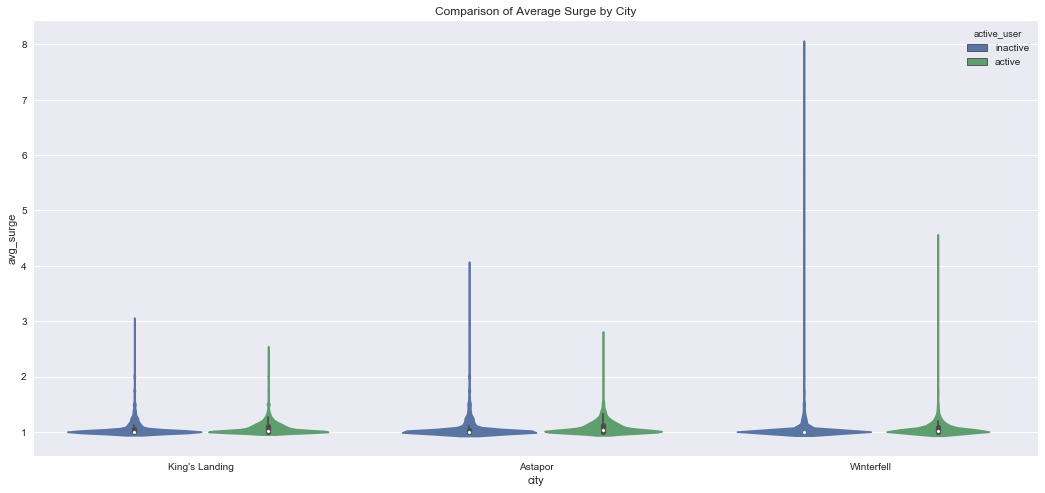

In [17]:
sb.violinplot(x="city", y="avg_surge", hue='active_user', data=df)
plt.title('Comparison of Average Surge by City')
plt.show()

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


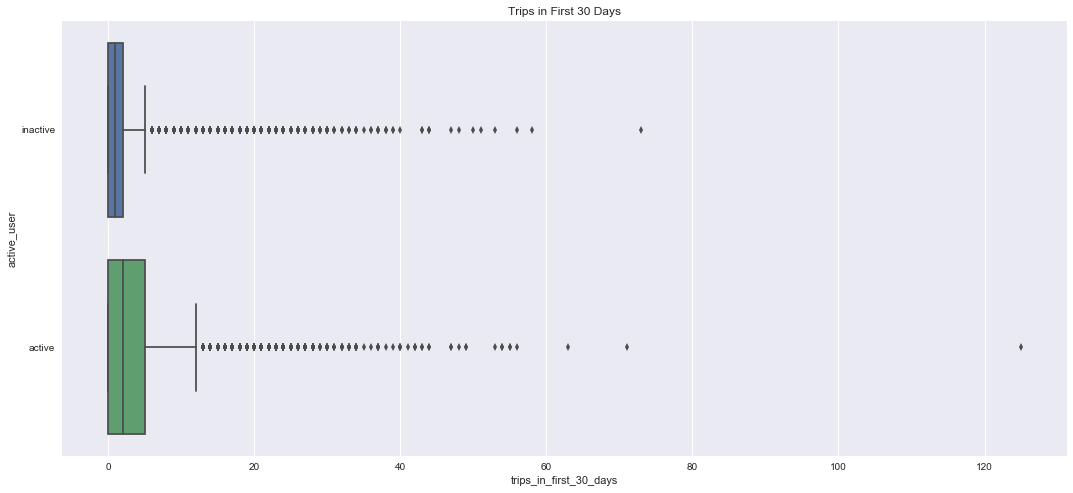

In [18]:
sb.boxplot(x='trips_in_first_30_days', y='active_user', data=df)
plt.title('Trips in First 30 Days')
plt.show()

In [19]:
df.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [20]:
df.ultimate_black_user.value_counts()

False    31146
True     18854
Name: ultimate_black_user, dtype: int64

## Exploratory Insights

Some insights gained from the exploratory analysis:
-  36% of the observed users were retained
-  Most users appear to be in the Winterfell area
-  Surge is more prevalent in Winterfell
-  Active users are more likely to have a trip within their first 30 days of signing up

## Feature Engineering 

The goal is now to predict whether or not a user will be active in their 6th month. First we will drop repetitive columns and columns that don't have much value for prediction. These columns are the last trip date, signup date, surge percentage, phone, and ultimate black status. I also combined the average rating by driver and average rating of driver into one column by taking the average of the two.

It appears that our features seem to have mostly skewed distributions, scaling will most likely be necessary for our modeling process.

Looking at a correlation analysis of our features, it appears that there is not a strong correlation between any two features.

In [43]:
prediction_df = df.drop(['last_trip_date', 'phone', 'signup_date', 'surge_pct', 'ultimate_black_user', 'retained_user'], axis=1)
city_dict = {"King's Landing": 1, 'Astapor': 2, 'Winterfell': 3}
active_user_dict = {'inactive': 0, 'active': 1}
prediction_df['city'] = df['city'].replace(city_dict)
prediction_df['active_user'] = df['active_user'].replace(active_user_dict)
prediction_df['combined_avg_driver_rating'] = df[['avg_rating_by_driver', 'avg_rating_of_driver']].mean(axis=1)
prediction_df = prediction_df.drop(['avg_rating_by_driver', 'avg_rating_of_driver'], axis=1)
cols = list(prediction_df.columns.values)
feature_cols = [col for col in cols if col != 'active_user']
prediction_df = prediction_df[feature_cols]
prediction_df.head()

,avg_dist,avg_surge,city,trips_in_first_30_days,weekday_pct,combined_avg_driver_rating
0,3.67,1.10,1,4,46.2,4.85
1,8.26,1.00,2,0,50.0,5.00
2,0.77,1.00,2,3,100.0,4.65
3,2.36,1.14,1,9,80.0,4.75
4,3.13,1.19,3,14,82.4,4.65


In [44]:
prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
avg_dist                      50000 non-null float64
avg_surge                     50000 non-null float64
city                          50000 non-null int64
trips_in_first_30_days        50000 non-null int64
weekday_pct                   50000 non-null float64
combined_avg_driver_rating    49933 non-null float64
dtypes: float64(4), int64(2)
memory usage: 2.3 MB


In [45]:
prediction_df['combined_avg_driver_rating'] = prediction_df['combined_avg_driver_rating'].fillna(prediction_df['combined_avg_driver_rating'].mean())

In [46]:
prediction_df.describe()

,avg_dist,avg_surge,city,trips_in_first_30_days,weekday_pct,combined_avg_driver_rating
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,1.074764,2.264120,2.278200,60.926084,4.704396
std,5.707357,0.222336,0.774321,3.792684,37.081503,0.438297
min,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
25%,2.420000,1.000000,2.000000,0.000000,33.300000,4.500000
50%,3.880000,1.000000,2.000000,1.000000,66.700000,4.850000
75%,6.940000,1.050000,3.000000,3.000000,100.000000,5.000000
max,160.960000,8.000000,3.000000,125.000000,100.000000,5.000000


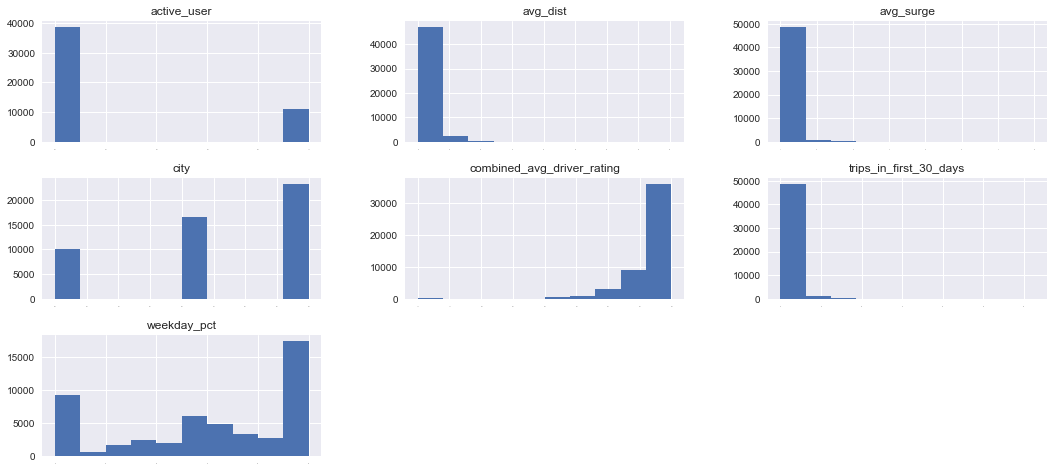

In [63]:
prediction_df.hist(sharex=False, sharey=False, xlabelsize=1)
plt.show()

In [47]:
prediction_df.corr()

,avg_dist,avg_surge,city,trips_in_first_30_days,weekday_pct,combined_avg_driver_rating
avg_dist,1.000000,-0.081491,0.011120,-0.136329,0.101652,0.080037
avg_surge,-0.081491,1.000000,-0.013036,-0.001841,-0.110071,-0.009590
city,0.011120,-0.013036,1.000000,0.011517,-0.026142,-0.126662
trips_in_first_30_days,-0.136329,-0.001841,0.011517,1.000000,0.050388,-0.041933
weekday_pct,0.101652,-0.110071,-0.026142,0.050388,1.000000,0.021002
combined_avg_driver_rating,0.080037,-0.009590,-0.126662,-0.041933,0.021002,1.000000


In [48]:
prediction_df['active_user'] = df['active_user'].replace(active_user_dict)
prediction_df['active_user'].value_counts()

0    38806
1    11194
Name: active_user, dtype: int64

In [27]:
print(len(prediction_df[prediction_df['active_user'] == 1]) / len(df))

0.22388


## Modeling and Approach

This is a binary classification problem, we will start with a few standard binary classification algorithms: logistic regression, K-Nearest Neighbors, and a Decision Tree Classifier. After observing their performance we will see if we can further improve our models by trying out some ensemble methods such as : Adaboost, Gradient Boosted Decision Tree, Random Forest, and Extremely Randomized Decision Tree. 

The key insight from our prediction dataframe analysis is the heavy target class imbalance. Only 22% of the observed data contains users that were active in their 6th month. As far as our prediction goes, guessing that a user will not be active in their 6th month will be correct 78% percent of the time. Due to this target class imbalance, accuracy will probably not be the best metric to evaluate model performance. A better metric to use for this problem would be observing the receiving operating characteristic (ROC) curve. This curve plots the the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings.

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [49]:
# split out into train and test

array = prediction_df.values

X = array[:,0:6].astype(float)
y = array[:,6]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

### Logistic Regression

Logistic regression is one of the go-to models used for binary classification and is known as a discriminative classifier. The goal is to draw a line in feature space that divides the 1 samples from the 0 samples. In other words, we wish to find the line which divides the samples between users that were active after 6 months and users that were not. In it's simplest form, logistic regression does this by computing the probability where a probability of less than 0.5 is classified as 0, and a probability of greater than 0.5 is classified as 1.

### K-Nearest Neighbors

The intuition behind K-Nearest Neighbors(KNN) is that samples close to each other in feature-space share a label. In other words: if a lot of samples in some area of the feature space belong to one class (active after 6 months) as compared to the other (non active after 6 months), we'll label that part of the feature space as belonging to that class. For a binary classification problem such as ours, this process will then classify the feature space into two class-based regions. Then, given the point in feature space, we find which region its in and its class.

KNN does this by scanning for the k nearest neighbors in the training set of the new sample. Before scanning, we must define a distance in the feature space to define which neighbors are "close". This distance is typically defined as the Euclidean distance, the sum of the square of the difference of each feature value between any two samples.

### Decision Tree

Decision trees are a fairly simple classifier and can be described as follows. 
-  At each step of the algorithm we consider a list of possible decision
-  For each possible decision we recalculate the predictor for that rule
-  We recalculate the loss for each possible decision
-  We choose the decision that reduces the loss by the largest amount

In [50]:
num_folds=10
seed=7
scoring='roc_auc'

models=[]
models.append(('LR', LogisticRegression()))
models.append(('KN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))

results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.655471 (0.008577)
KN: 0.710498 (0.011023)
CART: 0.610042 (0.010251)


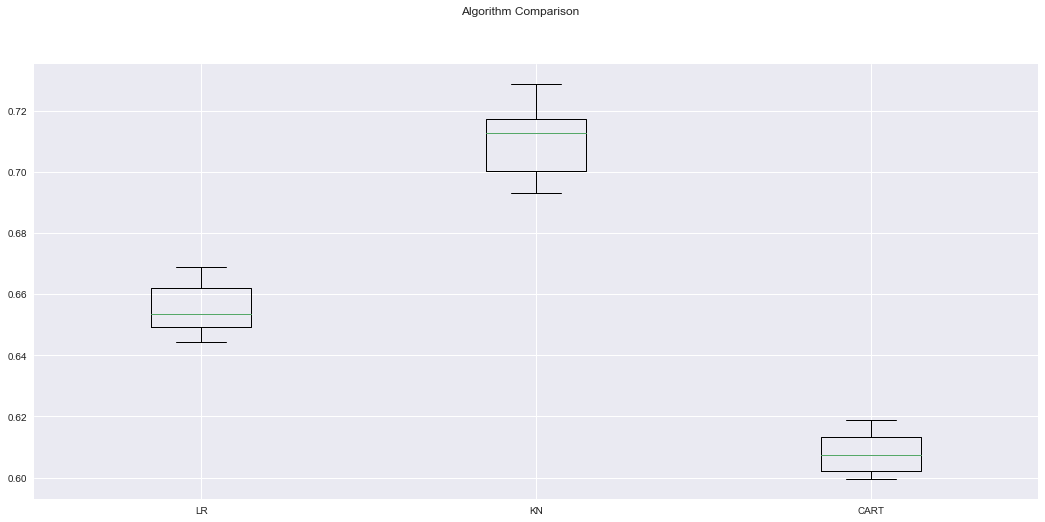

In [51]:
# Visualize comparisons with box plot

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

As we saw earlier in our feature analysis, the distribution of our features were not guassian and most had some skew. Logistic Regression and KNN both assume a gaussian distribution for their model so the unscaled distributions could be affecting performance. Let's see if scaling the data will improve performance.

In [52]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression())])))
pipelines.append(('ScaledKN', Pipeline([('Scaler', StandardScaler()), ('KN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()), ('CART', DecisionTreeClassifier())])))

scaled_results = []
scaled_names = []

for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    scaled_results.append(cv_results)
    scaled_names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

ScaledLR: 0.655484 (0.008568)
ScaledKN: 0.701964 (0.009024)
ScaledCART: 0.608440 (0.009276)


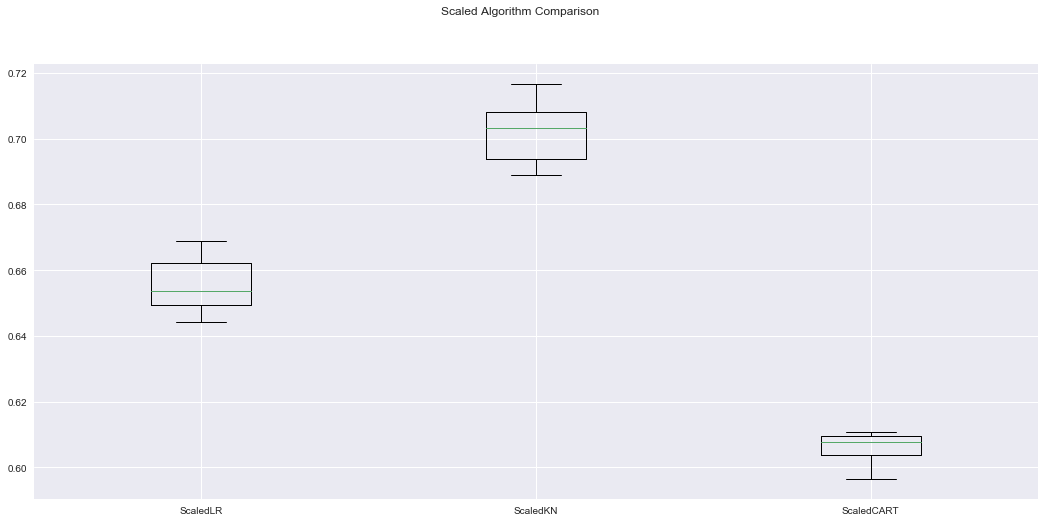

In [53]:
# Compare Algorithms

fig = plt.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(scaled_results)
ax.set_xticklabels(scaled_names)
plt.show()


Scaling did not seem to improve performance. Our top performing algorithm with KNN, let's see if we can optimize it to by tuning the model's number of neighbors parameter - the default used is 7. To tune this we will use the Grid Search function from sci-kit learn.

In [54]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = KNeighborsClassifier()
neighbors = [1,3,5,7,9,11,13,15,17,19,21]
param_grid = dict(n_neighbors=neighbors)

kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, y_train)
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, std, param))

Best: 0.754085 using {'n_neighbors': 21}
0.597119 (0.011326) with: {'n_neighbors': 1}
0.671246 (0.011339) with: {'n_neighbors': 3}
0.701549 (0.008564) with: {'n_neighbors': 5}
0.719531 (0.009275) with: {'n_neighbors': 7}
0.730535 (0.009842) with: {'n_neighbors': 9}
0.738175 (0.008406) with: {'n_neighbors': 11}
0.742706 (0.009044) with: {'n_neighbors': 13}
0.747299 (0.009443) with: {'n_neighbors': 15}
0.750252 (0.009000) with: {'n_neighbors': 17}
0.752661 (0.009313) with: {'n_neighbors': 19}
0.754085 (0.009423) with: {'n_neighbors': 21}


Now that we have tuned our KNN model to it's optimal performance, let's visualize our performance by plotting the roc curve.

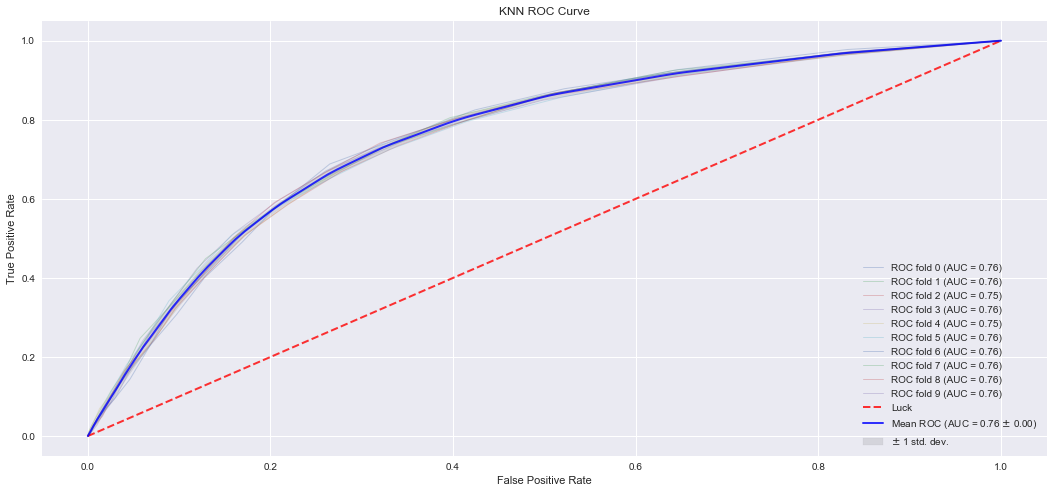

In [55]:
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=10)
classifier = KNeighborsClassifier(n_neighbors=21)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve')
plt.legend(loc="lower right")
plt.show()

The top ROC curve for our KNN model reaches an area under the curve of 0.76. Let's see if this training performance can be further improved with ensembles. Boosting could be beneficial for our target class imbalance and will be described further in depth below.

## AdaBoost

AdaBoost is short for Adaptive Boosting. First you have some base classifier, like a Decision tree for example.

First you assign to each of your data points to an equal weight and then:
-  fit that classifier (e.g. tree) on all your data
-  test to see how well your classifier predicts your data
-  data points that are miss-classified get a slightly higher weight

With our target class imbalance, boosting could help here due to users being active in 6 months being more difficult to classify. As a result, our boosted classifier will give more attention to those specific instances.

## Gradient Boosted Decision Tree

Gradient Boosted Decision Trees use the same theory as described in AdaBoost. The distinction lies in the weight assignment. When the loss is being calculated, the gradient of that loss is then used to update the weights as opposed to whether or not the prediction was correctly classified in Adaboost. It can be viewed as a more quantitative boosting method.

## Random Forest

In Random Forests we do the following: 
-  Take a random subsample of your data
-  Select m variables at random out of all M possible variables (independently for each node).
-  Find the best split on the selected m variables. Build out the entire tree.
-  repeat

## Extremely Randomized Forest

As in random forests, a random subset of candidate features is used, but instead of looking for the best splits, splits are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias.

In [56]:
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))

ensemble_results = []
ensemble_names = []

for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    ensemble_results.append(cv_results)
    ensemble_names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

AB: 0.785990 (0.007558)
GBM: 0.793980 (0.007775)
RF: 0.724514 (0.009641)
ET: 0.719672 (0.009368)


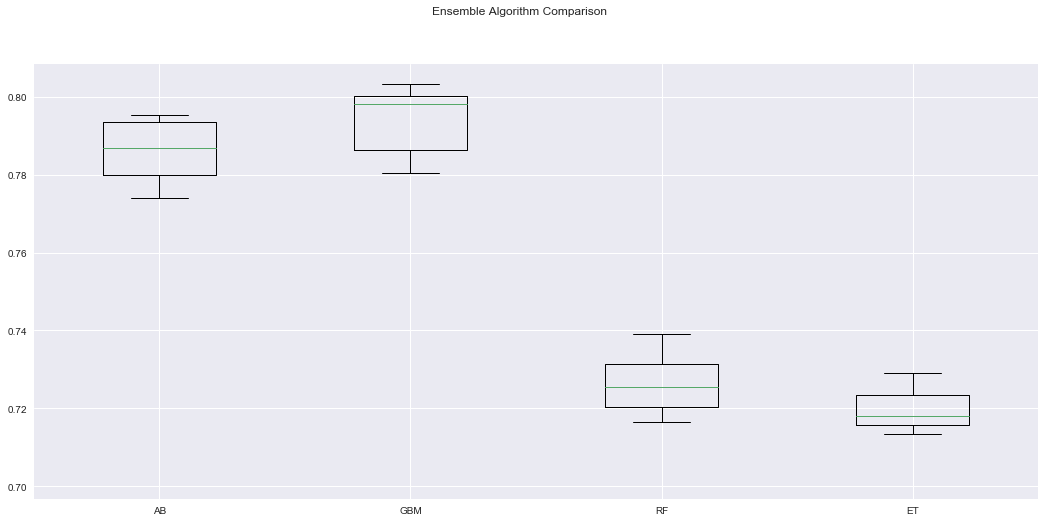

In [57]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(ensemble_results)
ax.set_xticklabels(ensemble_names)
plt.show()

It appears that the Gradient Boosted Decision Tree was the top performer. As expected boosting was able to improve our model's performance, and the two boosting algorithms performed significantly better than our too bagging algorithms. 

Now let's see if we can further increase our performance while also avoid overfitting our training data by tuning a few parameters in our GBM. A few that come to mind are the number of estimators (the number of sequential trees to be modeled), the maximum depth of the tree, and the minimum number of samples (or observations) which are required in a node to be considered for splitting. We will stick to just these three as tuning GBM's can be computationally expensive.

In [58]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=250,min_samples_leaf=50,
                                   max_depth=5,max_features='sqrt',subsample=0.8,random_state=10)

param_test1 = {'n_estimators':range(20,81,10)}

kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_test1, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, y_train)
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, std, param))

Best: 0.795402 using {'n_estimators': 80}
0.787645 (0.007275) with: {'n_estimators': 20}
0.790012 (0.007409) with: {'n_estimators': 30}
0.791865 (0.007635) with: {'n_estimators': 40}
0.793514 (0.007713) with: {'n_estimators': 50}
0.794066 (0.007784) with: {'n_estimators': 60}
0.794974 (0.007680) with: {'n_estimators': 70}
0.795402 (0.007686) with: {'n_estimators': 80}


In [59]:
model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,min_samples_leaf=50,
                                max_features='sqrt',subsample=0.8,random_state=10)

param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}

kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_test2, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, y_train)
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, std, param))

Best: 0.797425 using {'min_samples_split': 1000, 'max_depth': 9}
0.795576 (0.007079) with: {'min_samples_split': 200, 'max_depth': 5}
0.796045 (0.007620) with: {'min_samples_split': 400, 'max_depth': 5}
0.795477 (0.007346) with: {'min_samples_split': 600, 'max_depth': 5}
0.795343 (0.007541) with: {'min_samples_split': 800, 'max_depth': 5}
0.795077 (0.007647) with: {'min_samples_split': 1000, 'max_depth': 5}
0.796255 (0.008602) with: {'min_samples_split': 200, 'max_depth': 7}
0.796662 (0.007728) with: {'min_samples_split': 400, 'max_depth': 7}
0.796091 (0.007425) with: {'min_samples_split': 600, 'max_depth': 7}
0.796787 (0.007587) with: {'min_samples_split': 800, 'max_depth': 7}
0.796514 (0.007820) with: {'min_samples_split': 1000, 'max_depth': 7}
0.794990 (0.007934) with: {'min_samples_split': 200, 'max_depth': 9}
0.796126 (0.008111) with: {'min_samples_split': 400, 'max_depth': 9}
0.796101 (0.007510) with: {'min_samples_split': 600, 'max_depth': 9}
0.796934 (0.007274) with: {'min_samp

## Further Performance Evaluation

Now that we have our best model, let's observe the performance on the test set. In addition to the ROC curve, a couple other evaluation metrics that would work well here are the confusion matrix, and precision recall.

### Confusion Matrix

In a confusion matrix each row of the matrix represents the instances in a predicted class while each column represents the instances in an actual class. In the context of this problem a true positive represents a user that was active after 6 months and was labaled as active. A true negative represents a user that was inactive after 6 months and was labeled as inactive. A false positive represents a user that was labeled active but was actually inactive after 6 months, and a false negative represents a user that was labeled inactive but was actually active after 6 months.

### Precision Recall

The recall (also the true positive rate) is the ratio of true positive guesses among all positives, the precision is the ratio of the true positive guesses over all the positive guesses. Because precision and recall both provide valuable information about the quality of a classifier, we want to combine them into a single score. The F1 score is defined as the harmonic mean of recall and precision.

In [60]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = GradientBoostingClassifier(n_estimators= 80, max_depth=7, min_samples_split=1000, learning_rate=0.1,
                                  min_samples_leaf=50,
                                  max_features='sqrt',subsample=0.8,random_state=10)
model.fit(rescaledX, y_train)

# estimate accuracy on test set

rescaledTestX = scaler.transform(X_test)
predictions = model.predict(rescaledTestX)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[7346  463]
 [1512  679]]
             precision    recall  f1-score   support

        0.0       0.83      0.94      0.88      7809
        1.0       0.59      0.31      0.41      2191

avg / total       0.78      0.80      0.78     10000



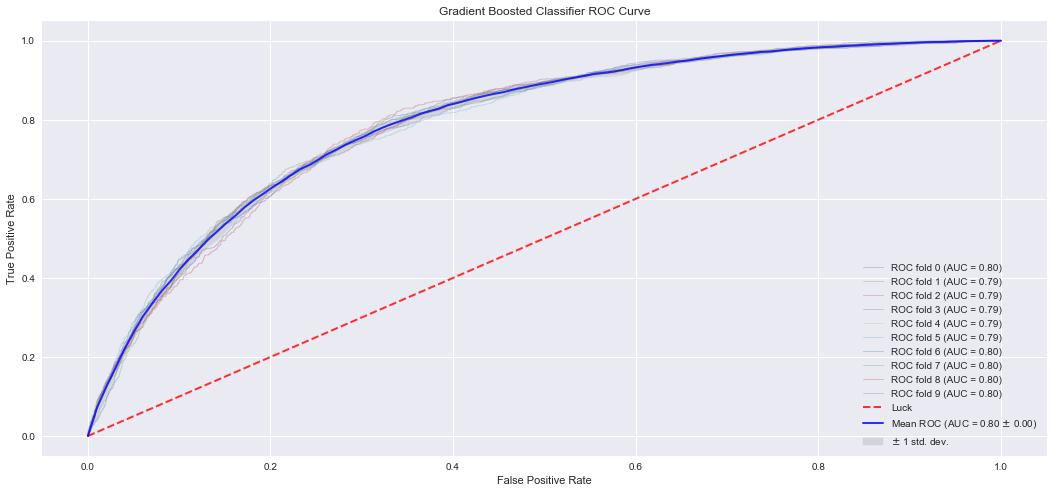

In [61]:
cv = StratifiedKFold(n_splits=10)
classifier = GradientBoostingClassifier(n_estimators= 80, max_depth=7, min_samples_split=1000, learning_rate=0.1,
                                  min_samples_leaf=50,
                                  max_features='sqrt',subsample=0.8,random_state=10)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boosted Classifier ROC Curve')
plt.legend(loc="lower right")
plt.show()

Our best model achieves a ROC curve with an area under of it 0.8, a step up from our KNN model. However, as we observe the confusion matrix and precision recall it is clear that our model is still having difficulty classifying our minority class which represents users who were active after 6 months. To further tackle the problem of a target class imbalance, we could subsample our datasets into folds that have a less of a target class discrepency so our model can learn our features of the minority class better.

Let's now observe what the most important features for prediction using the feature importances attribute of the GBM.

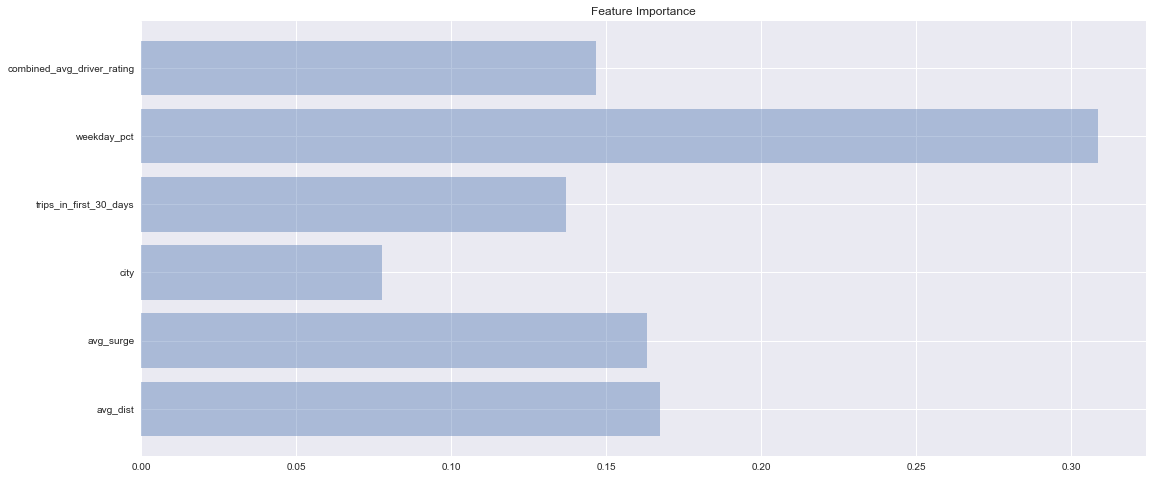

In [62]:
y_pos = np.arange(len(feature_cols))

plt.barh(y_pos, model.feature_importances_, align='center', alpha=0.4)
plt.yticks(y_pos, feature_cols)
plt.title('Feature Importance')

plt.show()

# Conclusion and Future Directions

Moving forward for Ultimate there are a few key takeaways that we can take from this analysis that could improve user retention:
-  With this model Ultimate is able to predicting non-active users very well, while having more difficulty predicting active users
-  It appears that the percentage used on weekdays is the most important feature, using that knowledge Ultimate can look for ways to get users to drive specifically during the week to prolong activity
-  Active users were more likely to have a trip in their first 30 days, knowing this Ultimate could look for way to incentive users early on after their signup date
-  There are clear market opportunities in King's Landing especially as most of the dataset did not contain users from King's Landing
-  The key is being able to integrate the service into their daily lives, by focusing on their use within their first 30 days of signing up as well as usage during the week, longterm user retention can be retained